In [65]:
import numpy as np
import pandas as pd 
import re
import matplotlib.pyplot as plt 
import seaborn as sns
import joblib 
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import sklearn.metrics as mt
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import (
    export_graphviz,
    DecisionTreeClassifier,
    DecisionTreeRegressor
    )
    ## check


from sklearn.ensemble import(
    RandomForestClassifier, ## check
    VotingClassifier,
    GradientBoostingClassifier,
    RandomForestRegressor
    )
from sklearn.metrics import(
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay, 
    recall_score,
    precision_score,
    mean_squared_error,
    mean_absolute_error,
    r2_score
    )     ##check
from sklearn.model_selection import (
    train_test_split,
    KFold ,
    StratifiedShuffleSplit,  ## check
    cross_val_score,     ##check
    RandomizedSearchCV
    )


In [66]:
 # 1. daily raw data 가져오기
#df= pd.read_excel(r"total_raw.xlsx", sheet_name="auto", header=0, index_col=0)
#df = pd.read_excel(r"total_raw.xlsx", sheet_name="construct", header=0, index_col=0)
#df = pd.read_excel(r"total_raw.xlsx", sheet_name="capital_market", header=0, index_col=0)
#df = pd.read_excel(r"total_raw.xlsx", sheet_name="chemicals", header=0, index_col=0)
#df = pd.read_excel(r"total_raw.xlsx", sheet_name="equipment", header=0, index_col=0)
#df= pd.read_excel(r"total_raw.xlsx", sheet_name="media", header=0, index_col=0)
#df = pd.read_excel(r"total_raw.xlsx", sheet_name="insurance", header=0, index_col=0)
#df = pd.read_excel(r"total_raw.xlsx", sheet_name="transport", header=0, index_col=0)
#df = pd.read_excel(r"total_raw.xlsx", sheet_name="health_care", header=0, index_col=0)
#df = pd.read_excel(r"total_raw.xlsx", sheet_name="semi", header=0, index_col=0)
#df = pd.read_excel(r"total_raw.xlsx", sheet_name="bank", header=0, index_col=0)
#df = pd.read_excel(r"total_raw.xlsx", sheet_name="steel", header=0, index_col=0)
#df = pd.read_excel(r"total_raw.xlsx", sheet_name="staples", header=0, index_col=0)
df_kospi = pd.read_excel(r"industry_data_3.xlsx", sheet_name="kospi", header=0, index_col=0)
df = pd.read_excel(r"total_raw.xlsx", sheet_name="kospi", header=0, index_col=0)
#df_kospi = pd.read_excel(r"industry_data.xlsx", sheet_name="kospi", header=0, index_col=0)



In [67]:
df.tail(2)
df_kospi.tail(2)

#df_construct.head(2)
#df_capital_market.head(2)
#df_chemicals.head(2)
#df_equipment.head(2)
#df_media.head(2)
#df_insurance.head(2)
#df_transport.head(2)
#df_health_care.head(2)
#df_semi.head(2)
#df_bank.head(2)
#df_steel.head(2)
#df_staples.head(2)
#df_discretionary.head(2)
#df_kospi.head(2)

,kospi,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,수익률,일자.1,kospi.1,20영업일 수익률,kospi.2,...,Unnamed: 15,base_date,kospi.4,일자.3,kospi.5,Unnamed: 20,base_date.1,kospi.6,일자.4,kospi.7
일자,,,,,,,,,,,,,,,,,,,,,
2024-02-28,2652.29,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,...,NaN,NaT,NaN,NaT,2nd,2019-07-29,NaT,NaN,NaT,NaN
2024-02-29,2642.36,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,...,NaN,NaT,NaN,NaT,2nd,2019-07-30,NaT,NaN,NaT,NaN


In [68]:
columns_to_drop = ["KOSPI지수", "KOSPI지수_20", "KOSPI지수_60"]
columns_exist = [col for col in columns_to_drop if col in df_kospi.columns]
if columns_exist:
    df_kospi = df_kospi.drop(columns=columns_exist)

df_kospi.tail(2)


,kospi,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,수익률,일자.1,kospi.1,20영업일 수익률,kospi.2,...,Unnamed: 15,base_date,kospi.4,일자.3,kospi.5,Unnamed: 20,base_date.1,kospi.6,일자.4,kospi.7
일자,,,,,,,,,,,,,,,,,,,,,
2024-02-28,2652.29,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,...,NaN,NaT,NaN,NaT,2nd,2019-07-29,NaT,NaN,NaT,NaN
2024-02-29,2642.36,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,...,NaN,NaT,NaN,NaT,2nd,2019-07-30,NaT,NaN,NaT,NaN


In [69]:
df_kospi["kospi_1"]


일자
2010-01-04       down
2010-01-05       down
2010-01-06       down
2010-01-07       down
2010-01-08       down
               ...   
2024-02-23    neutral
2024-02-26    neutral
2024-02-27    neutral
2024-02-28    neutral
2024-02-29    neutral
Name: kospi_1, Length: 3495, dtype: object

In [70]:
df['kospi'] = None
df.head()

,kospi,원/달러 환율,원/엔 환율,국채 3년물,국채 10년물,PER,PBR,VKOSPI,treasury_10_3_diff,T10Y2Y,...,PPI_60,USA_Vehi_Sell_60,구리 선물_60,중국 고정자산투자(yoy)_60,중국 PMI_60,금 선물_60,MSCI_EMER_60,달러 인덱스_60,중국소매판매_60,중국 산업 생산_60
base_date,,,,,,,,,,,,,,,,,,,,,
2010-03-31,None,1131.3,1213.45,3.895,4.94,24.35,1.36,13.47,1.06,2.82,...,0.000217,-0.001695,0.000646,-0.003116,-0.001932,-0.000143,0.000025,0.000891,0.006217,-0.008068
2010-04-01,None,1126.4,1204.45,3.895,4.92,24.13,1.38,13.63,1.07,2.84,...,0.000212,-0.001737,0.000842,-0.003191,-0.001859,-0.000108,0.000181,0.000870,0.006153,-0.007687
2010-04-05,None,1123.1,1188.97,3.840,4.95,24.22,1.38,13.56,1.11,2.83,...,0.000207,-0.001560,0.001063,-0.003258,-0.001785,-0.000062,0.000369,0.000855,0.006087,-0.007304
2010-04-06,None,1123.2,1195.40,3.845,4.94,24.24,1.38,14.75,1.10,2.84,...,0.000200,-0.001339,0.001314,-0.003318,-0.001709,0.000015,0.000572,0.000841,0.006020,-0.006919
2010-04-07,None,1120.5,1191.13,3.820,4.88,24.26,1.39,14.22,1.06,2.83,...,0.000193,-0.001121,0.001518,-0.003370,-0.001632,0.000112,0.000767,0.000835,0.005952,-0.006532


In [71]:
df['kospi']  =df_kospi["kospi_1"]
df.head()


,kospi,원/달러 환율,원/엔 환율,국채 3년물,국채 10년물,PER,PBR,VKOSPI,treasury_10_3_diff,T10Y2Y,...,PPI_60,USA_Vehi_Sell_60,구리 선물_60,중국 고정자산투자(yoy)_60,중국 PMI_60,금 선물_60,MSCI_EMER_60,달러 인덱스_60,중국소매판매_60,중국 산업 생산_60
base_date,,,,,,,,,,,,,,,,,,,,,
2010-03-31,neutral,1131.3,1213.45,3.895,4.94,24.35,1.36,13.47,1.06,2.82,...,0.000217,-0.001695,0.000646,-0.003116,-0.001932,-0.000143,0.000025,0.000891,0.006217,-0.008068
2010-04-01,neutral,1126.4,1204.45,3.895,4.92,24.13,1.38,13.63,1.07,2.84,...,0.000212,-0.001737,0.000842,-0.003191,-0.001859,-0.000108,0.000181,0.000870,0.006153,-0.007687
2010-04-05,down,1123.1,1188.97,3.840,4.95,24.22,1.38,13.56,1.11,2.83,...,0.000207,-0.001560,0.001063,-0.003258,-0.001785,-0.000062,0.000369,0.000855,0.006087,-0.007304
2010-04-06,down,1123.2,1195.40,3.845,4.94,24.24,1.38,14.75,1.10,2.84,...,0.000200,-0.001339,0.001314,-0.003318,-0.001709,0.000015,0.000572,0.000841,0.006020,-0.006919
2010-04-07,down,1120.5,1191.13,3.820,4.88,24.26,1.39,14.22,1.06,2.83,...,0.000193,-0.001121,0.001518,-0.003370,-0.001632,0.000112,0.000767,0.000835,0.005952,-0.006532


In [72]:
# def classify_movement(growth_rate):
#     if growth_rate < 0:
#         return "down"
#     elif growth_rate < 0.04:
#         return "neutral"
#     else:
#         return "up"

# def calculate_growth_rate_with_classification_from_dataframe(df):
#     kospi_series = df_kospi["kospi"].tolist()  # "KOSPI지수" 열의 값을 숫자형으로 변환하여 리스트로 변환
#     if len(kospi_series) <= 20:
#         return []  # "KOSPI지수" 열의 길이가 20 이하인 경우 빈 리스트 반환

#     forward_stage = []
#     for i in range(20, len(kospi_series)):
#         current_value = kospi_series[i]
#         growth_rate = (current_value - kospi_series[i-20]) / kospi_series[i-20]
#         movement = classify_movement(growth_rate)
#         forward_stage.append(movement)
    
#     # 최대 3265개까지만 유지하도록 제한
#     forward_stage = forward_stage[:3265]
    
#     # 남은 값은 None으로 채움
#     forward_stage.extend([None] * (len(df) - len(forward_stage)))
    
#     return forward_stage

# forward_stage_from_df = calculate_growth_rate_with_classification_from_dataframe(df)
# df_kospi['forward_stage'] = forward_stage_from_df
# print(forward_stage_from_df)


In [73]:
# df.drop(columns=df.columns[1], inplace=True)
# df.tail()

In [74]:
column_names = [
    'auto',    
    # 'KOSPI Index',
    'Exchange Rate (KRW/USD)', 'Exchange Rate (KRW/JPY)',
    '3-Year Treasury Bond', '10-Year Treasury Bond', 'Price-to-Earnings Ratio', 
    'Price-to-Book Ratio', 'Volatility Index of KOSPI',
    '10-Year Treasury Bond Minus 3-Year Treasury Bond',
    '10-Year Treasury Yield Minus 2-Year Treasury Yield', 'USA Consumer Price Index', 
    'USA Employment Inflation', 'Yield Gap Percentage', 'Consumer Price Index', 
    'Export', 'West Texas Intermediate (WTI) Crude Oil Price', 
    '2-Year Treasury Constant Maturity Rate', '10-Year Treasury Constant Maturity Rate',
    'Treasury Inflation-Protected Securities (TIPS) Yield', 'Volatility Index (VIX)', 
    'Producer Price Index (PPI)', 'USA Vehicle Sales', 'Copper Futures',
    'China Fixed Asset Investment (Year-over-Year)', 
    'China Purchasing Managers\' Index (PMI)', 'Gold Futures', 
    'MSCI Emerging Markets Index', 'US Dollar Index', 'China Retail Sales',
    'China Industrial Production', 
    # 'KOSPI Index (20-day Moving Average)', 
    'Exchange Rate (KRW/USD) (20-day Moving Average)',
    'Exchange Rate (KRW/JPY) (20-day Moving Average)', 
    '3-Year Treasury Bond (20-day Moving Average)', 
    '10-Year Treasury Bond (20-day Moving Average)', 
    'Price-to-Earnings Ratio (20-day Moving Average)', 
    'Price-to-Book Ratio (20-day Moving Average)', 
    'Volatility Index of KOSPI (20-day Moving Average)',
    '10-Year Treasury Bond Minus 3-Year Treasury Bond (20-day Moving Average)', 
    '10-Year Treasury Yield Minus 2-Year Treasury Yield (20-day Moving Average)',
    'T10Y2Y_20', 'usa_cpi_20', 'us_e_infla_20', 'yield_gap(%)_20', 'cpi_20',
    'export_20', 'WTI_20', 'DGS2_20', 'DGS10_20', 'TIPS_20', 'VIX_20', 'PPI_20',
    'USA_Vehi_Sell_20', 'Copper Futures (20-day Moving Average)', 'China Fixed Asset Investment (Year-over-Year) (20-day Moving Average)',
    'China Purchasing Managers\' Index (PMI) (20-day Moving Average)', 'Gold Futures (20-day Moving Average)',
    'MSCI Emerging Markets Index (20-day Moving Average)', 'US Dollar Index (20-day Moving Average)',
    'China Retail Sales (20-day Moving Average)', 'China Industrial Production (20-day Moving Average)',
    # 'KOSPI Index (60-day Moving Average)', 
    'Exchange Rate (KRW/USD) (60-day Moving Average)',
    'Exchange Rate (KRW/JPY) (60-day Moving Average)', '3-Year Treasury Bond (60-day Moving Average)',
    '10-Year Treasury Bond (60-day Moving Average)', 'Price-to-Earnings Ratio (60-day Moving Average)',
    'Price-to-Book Ratio (60-day Moving Average)', 'VKOSPI (60-day Moving Average)',
    'Treasury 10-Year Minus 3-Year Differential (60-day Moving Average)',
    '10-Year Treasury Yield Minus 2-Year Treasury Yield (60-day Moving Average)',
    'USA Consumer Price Index (60-day Moving Average)', 'USA Employment Inflation (60-day Moving Average)',
    'Yield Gap Percentage (60-day Moving Average)', 'Consumer Price Index (60-day Moving Average)',
    'Export (60-day Moving Average)', 'West Texas Intermediate (WTI) Crude Oil Price (60-day Moving Average)',
    '2-Year Treasury Constant Maturity Rate (60-day Moving Average)',
    '10-Year Treasury Constant Maturity Rate (60-day Moving Average)',
    'Treasury Inflation-Protected Securities (TIPS) Yield (60-day Moving Average)',
    'Volatility Index (VIX) (60-day Moving Average)', 'Producer Price Index (PPI) (60-day Moving Average)',
    'USA Vehicle Sales (60-day Moving Average)', 'Copper Futures (60-day Moving Average)',
    'China Fixed Asset Investment (Year-over-Year) (60-day Moving Average)',
    'China Purchasing Managers\' Index (PMI) (60-day Moving Average)', 'Gold Futures (60-day Moving Average)',
    'MSCI Emerging Markets Index (60-day Moving Average)', 'US Dollar Index (60-day Moving Average)',
    'China Retail Sales (60-day Moving Average)', 'China Industrial Production (60-day Moving Average)'
]

def check_english_only_in_list(lst):
    for item in lst:
        if not item.isascii():
            return False
    return True

# 검사 실행
if check_english_only_in_list(column_names):
    print("주어진 목록에는 영어만 포함되어 있습니다.")
else:
    print("주어진 목록에는 영어 이외의 문자가 포함되어 있습니다.")

    
    

df.rename(columns=dict(zip(df.columns, column_names)), inplace=True)

print("facter type:\n %s " % df.columns)
print("갯수 : %i " %len(df.columns))

주어진 목록에는 영어만 포함되어 있습니다.
facter type:
 Index(['auto', 'Exchange Rate (KRW/USD)', 'Exchange Rate (KRW/JPY)',
       '3-Year Treasury Bond', '10-Year Treasury Bond',
       'Price-to-Earnings Ratio', 'Price-to-Book Ratio',
       'Volatility Index of KOSPI',
       '10-Year Treasury Bond Minus 3-Year Treasury Bond',
       '10-Year Treasury Yield Minus 2-Year Treasury Yield',
       'USA Consumer Price Index', 'USA Employment Inflation',
       'Yield Gap Percentage', 'Consumer Price Index', 'Export',
       'West Texas Intermediate (WTI) Crude Oil Price',
       '2-Year Treasury Constant Maturity Rate',
       '10-Year Treasury Constant Maturity Rate',
       'Treasury Inflation-Protected Securities (TIPS) Yield',
       'Volatility Index (VIX)', 'Producer Price Index (PPI)',
       'USA Vehicle Sales', 'Copper Futures',
       'China Fixed Asset Investment (Year-over-Year)',
       'China Purchasing Managers' Index (PMI)', 'Gold Futures',
       'MSCI Emerging Markets Index', 'US Dollar

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3265 entries, 2010-03-31 to 2024-01-11
Data columns (total 88 columns):
 #   Column                                                                        Non-Null Count  Dtype  
---  ------                                                                        --------------  -----  
 0   auto                                                                          3265 non-null   object 
 1   Exchange Rate (KRW/USD)                                                       3265 non-null   float64
 2   Exchange Rate (KRW/JPY)                                                       3265 non-null   float64
 3   3-Year Treasury Bond                                                          3265 non-null   float64
 4   10-Year Treasury Bond                                                         3265 non-null   float64
 5   Price-to-Earnings Ratio                                                       3265 non-null   float64
 6   Price-to-Book 

In [76]:

# 2. features, label 전체데이터 생성
# X, y는 최근일까지 포함한 전 데이터. X_past, y_past는 결과가 확인된 61일전까지의 데이터
# 결측치가 있는 행 제거

df_dropna = df.dropna()

if df_dropna.empty:
    print("error")
else:
    # 종속 변수(y) 및 독립 변수(X) 설정
    y = df_dropna['auto']
    X = df_dropna.drop(columns=['auto'])
    # 최적화된 코드를 사용하여 y_past 및 X_past 생성
    # 위에서 이미 결측치를 제거하였으므로 추가적인 처리가 필요하지 않습니다.
    # 여기서 AUTO 는 NUTRAL UP DOWN 으로 3개로 구분 

In [77]:

# 3. train, test 나누기

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=0)

normalizer = StandardScaler()

X_train = normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)

print(f'Train set dimension is {X_train.shape}')
print(f'Test set dimension is {X_test.shape}')
# 훈련 데이터와 테스트 데이터의 클래스 비율 확인
train_class_counts = {label: sum(y_train == label) for label in set(y)}
test_class_counts = {label: sum(y_test == label) for label in set(y)}

print("훈련 데이터 클래스 비율:", train_class_counts)
print("테스트 데이터 클래스 비율:", test_class_counts) 


Train set dimension is (2612, 87)
Test set dimension is (653, 87)
훈련 데이터 클래스 비율: {'up': 441, 'neutral': 995, 'down': 1176}
테스트 데이터 클래스 비율: {'up': 97, 'neutral': 244, 'down': 312}


### 여러가지 실험을 했다
1. logistic_regression
2. random_forest
3. gradient_boosting
4. svm
5. neural_network

In [78]:
# 각 분류기 생성
logistic_regression = LogisticRegression()
random_forest = RandomForestClassifier()
gradient_boosting = GradientBoostingClassifier()
svm = SVC()
neural_network = MLPClassifier()
knn = KNeighborsClassifier()
decision_tree = DecisionTreeClassifier()

# Voting Classifier 생성
voting_classifier = VotingClassifier(
    estimators=[
        ('lr', logistic_regression), 
        ('rf', random_forest), 
        ('gb', gradient_boosting), 
        ('svm', svm), 
        ('nn', neural_network),
        ('knn', knn),
        ('dt', decision_tree)
    ],
    voting='hard'
)

# 모델별 정확도 저장
accuracies = {}

models = {
    'Logistic Regression': logistic_regression,
    'Random Forest': random_forest,
    'Gradient Boosting': gradient_boosting,
    'Support Vector Machine': svm,
    'Neural Network': neural_network,
    'K-Nearest Neighbors': knn,
    'Decision Tree': decision_tree,
    'Voting Classifier': voting_classifier
}
best_accuracy=0
# 모델 학습 및 평가
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies[name] = accuracy
    print(f"{name}의 정확도: {accuracy}")
    # 최고의 정확도를 가진 모델 찾기
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
# 가장 높은 정확도를 가진 모델 찾기
best_model_name = max(accuracies, key=accuracies.get)
best_accuracy = accuracies[best_model_name]

print(f"최고의 성능은 {best_model_name} 모델로, 정확도는 {best_accuracy:.3f}입니다.")

Logistic Regression의 정확도: 0.6401225114854517


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Random Forest의 정확도: 0.8407350689127105
Gradient Boosting의 정확도: 0.7886676875957122
Support Vector Machine의 정확도: 0.777947932618683


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Network의 정확도: 0.8300153139356815
K-Nearest Neighbors의 정확도: 0.8085758039816233
Decision Tree의 정확도: 0.8101071975497703


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Voting Classifier의 정확도: 0.8269525267993875
최고의 성능은 Random Forest 모델로, 정확도는 0.841입니다.


### 최고의 성능은 Random Forest 모델로, 정확도는 0.8 대략 정확도 80%


### 그러면은 단순 모델링을 해보자

In [79]:
# Train set에 대한 성능
rfc=best_model
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_train)
acc = accuracy_score(y_true = y_train, y_pred =y_pred)
print("Train set에 대한 성능")  
print(f"정확도:{acc:0.4f}")  

# Test set에 대한 성능
y_pred = rfc.predict(X_test)
acc = accuracy_score(y_true = y_test, y_pred =y_pred)
print("\n")  
print("Test set에 대한 성능")  
print(f"정확도:{acc:0.4f}")  

Train set에 대한 성능
정확도:1.0000


Test set에 대한 성능
정확도:0.8515


### test set에 대해서 성능이 한 81%정도 나온다 약간 상승!

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:20<00:00,  1.44it/s]


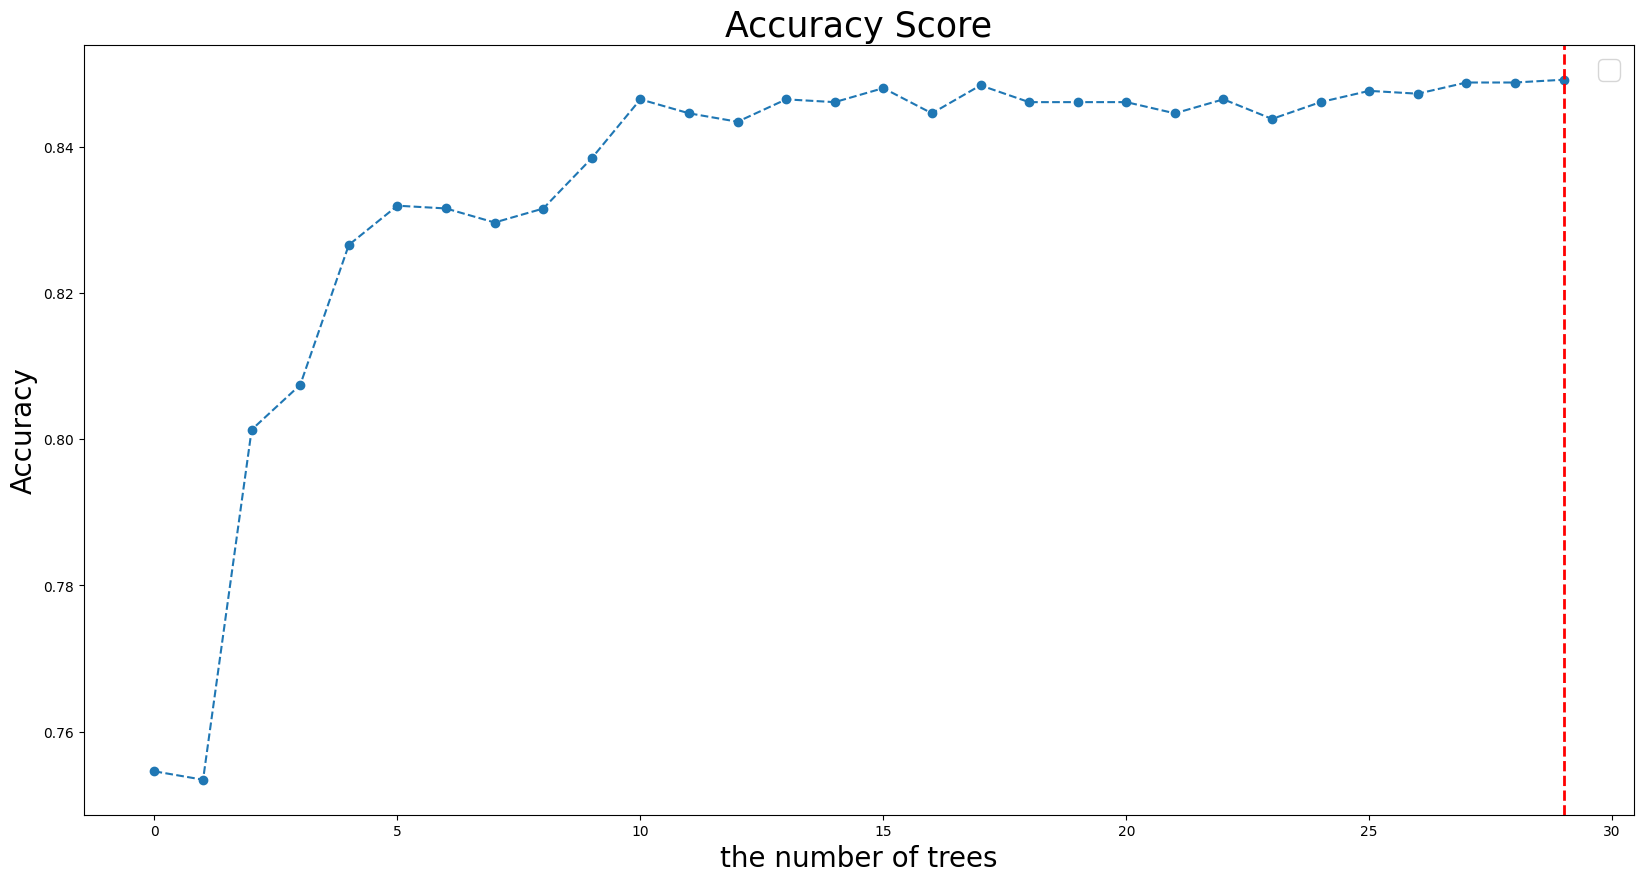

In [80]:
cv_scores = []

estimator_list =[i for i in range(30)]
for i in tqdm(range(30)):
    rfc = RandomForestClassifier(n_estimators=i+1,
                                 max_leaf_nodes= 300,
                                 n_jobs=-1,
                                 random_state=0)
    score = cross_val_score(rfc, X_train, y_train, cv=10, scoring = 'accuracy').mean()
    cv_scores.append(score)

best_e = [estimator_list[i] for i in range(len(cv_scores)) if cv_scores[i] == np.max(cv_scores)]
plt.figure(figsize=(20,10))
plt.legend(["Cross validation scores"], fontsize=20)
plt.plot(estimator_list,cv_scores, marker='o', linestyle='dashed')
plt.xlabel("the number of trees", fontsize=20 )
plt.ylabel("Accuracy", fontsize=20)
plt.title("Accuracy Score", fontsize=25)
plt.axvline(best_e[0], color='r', linestyle='--', linewidth=2)
#수직으로 선을 그어어줘라!
plt.show()

100%|██████████| 30/30 [00:27<00:00,  1.08it/s]


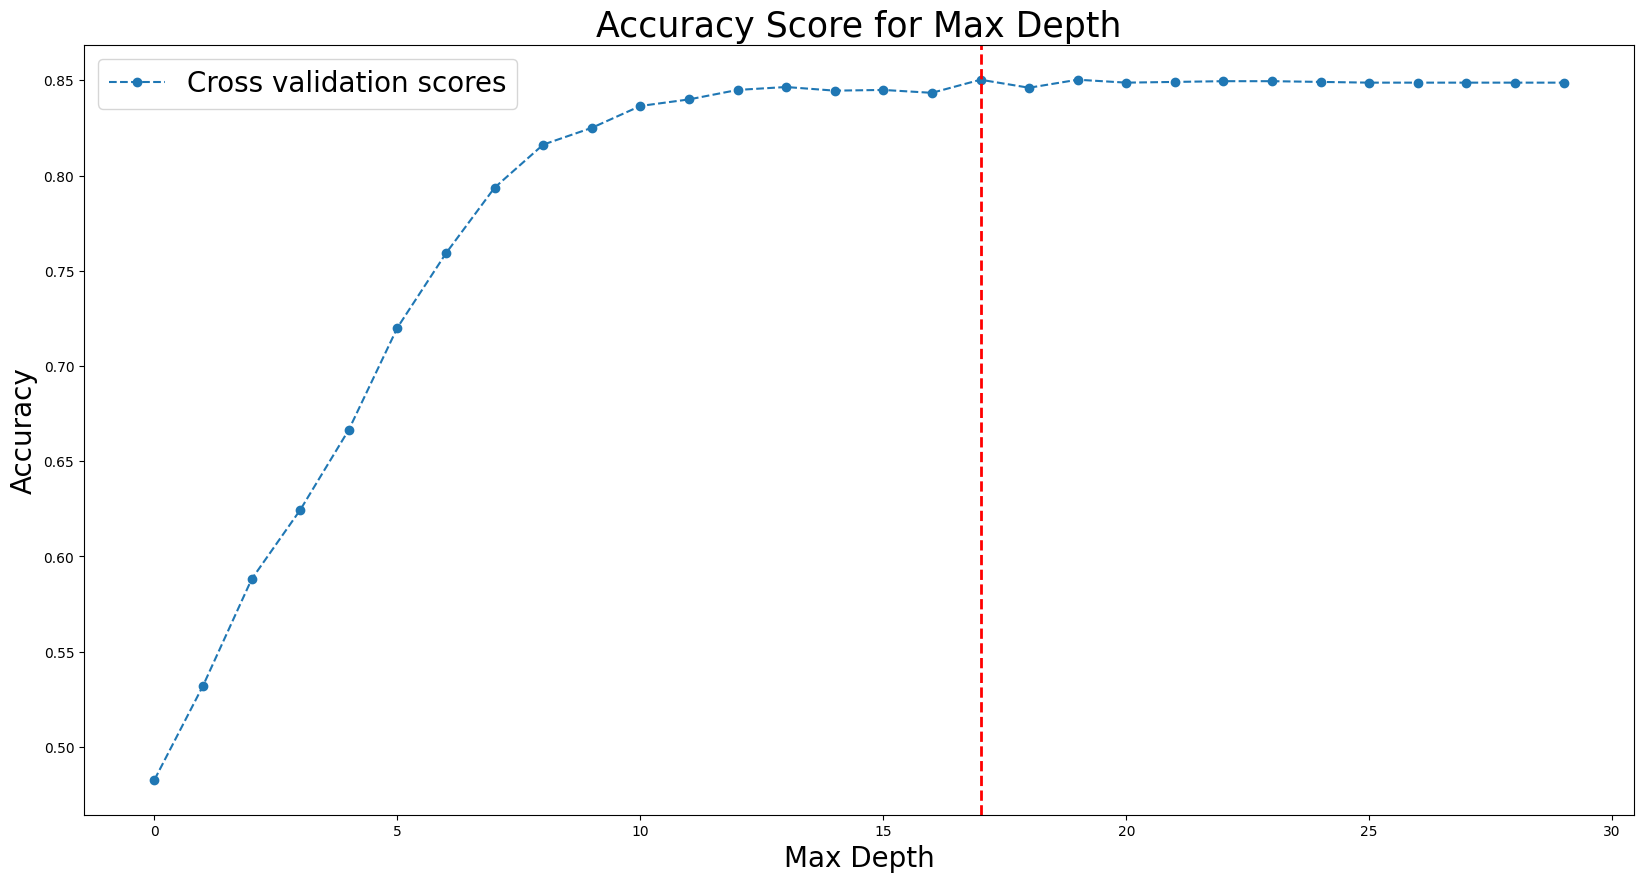

In [81]:
cv_scores_depth = []
depth_list =[i for i in range(30)]
for i in tqdm(range(30)):
    rfc = RandomForestClassifier(n_estimators=best_e[0],
                                 max_depth=i+1,
                                 max_leaf_nodes=300,
                                 n_jobs=-1,
                                 random_state=0)
    score = cross_val_score(rfc, X_train, y_train, cv=10, scoring='accuracy').mean()
    cv_scores_depth.append(score)

best_depth = [depth_list[i] for i in range(len(cv_scores_depth)) if cv_scores_depth[i] == np.max(cv_scores_depth)]
plt.figure(figsize=(20,10))
plt.plot(depth_list, cv_scores_depth, marker='o', linestyle='dashed')
plt.axvline(best_depth[0], color='r', linestyle='--', linewidth=2)
plt.legend(["Cross validation scores"], fontsize=20)
plt.xlabel("Max Depth", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.title("Accuracy Score for Max Depth", fontsize=25)
plt.show()


In [82]:
print(f"최적의 tree개수:{best_e[0]+1}")
print(f"최적의 depth개수:{best_depth[0]+1}")

print("\n")  
print("Train set에 대한 성능 (10 fold cross validation)")  
print(f"정확도:{max(cv_scores):0.4f}")  

최적의 tree개수:30
최적의 depth개수:18


Train set에 대한 성능 (10 fold cross validation)
정확도:0.8491


In [83]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# 튜닝할 하이퍼파라미터 조합 지정
param_grid = {
    'n_estimators':[best_e[0]-20,best_e[0]-10,best_e[0],best_e[0]+10,best_e[0]+20],  # 결정 트리 개수
    'max_depth':[ best_depth[0]-20,best_depth[0]-10,best_depth[0],best_depth[0]+10,best_depth[0]+20],  # 최대 깊이
    'max_leaf_nodes': [None],  # 리프 노드의 최대 개수
}

# 그리드 서치 모델 생성
rfc = RandomForestClassifier(random_state=0)
grid_search = GridSearchCV(rfc, param_grid ,cv=10,scoring='accuracy')

# 그리드 서치 수행
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 조합 출력
print("Best Parameters:", grid_search.best_params_)

# 최적의 모델 추출
best_rfc = grid_search.best_estimator_

# 테스트 데이터에 대한 예측
y_pred = best_rfc.predict(X_test)

# 정확도 계산
acc = accuracy_score(y_true=y_test, y_pred=y_pred)
print("튜닝된 모델에 대한 성능")  
print(f"정확도: {acc:.4f}")
#정확도: 0.8147


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
50 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Py

Best Parameters: {'max_depth': 37, 'max_leaf_nodes': None, 'n_estimators': 29}
튜닝된 모델에 대한 성능
정확도: 0.8377


In [84]:
# 최적의 하이퍼 파라미터 셋
grid_search.best_params_

{'max_depth': 37, 'max_leaf_nodes': None, 'n_estimators': 29}

### 조금더 상승했다!

In [85]:
# best_rfc = RandomForestClassifier(n_estimators= best_e[0],max_depth=best_depth[0],n_jobs=-1,random_state=0)
# # param_grid = {
# #     'max_depth': [10,14,18,22],
# #     'max_leaf_nodes': [100,200,300,400,500],
# #     'criterion':['entropy'],
# #     'max_features':['sqrt']
# # }
# # CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=10, verbose=1 ,n_jobs=-1)
# # CV_rfc.fit(X_train, y_train)

In [86]:
# # 최적의 하이퍼 파라미터 셋
# CV_rfc.best_params_

In [87]:
# result_table = pd.DataFrame(CV_rfc.cv_results_)
# result_table = result_table.sort_values(by='mean_test_score', ascending=False)
# print(result_table[['params', 'mean_test_score']])

In [88]:
# best_rfc = CV_rfc.best_estimator_
# best_rfc.fit(X_train, y_train)

In [89]:
# Train set에 대한 성능
best_rfc.fit(X_train, y_train)
y_pred = best_rfc.predict(X_train)
acc = accuracy_score(y_true = y_train, y_pred =y_pred)
print("Train set에 대한 성능")  
print(f"정확도:{acc:0.4f}")  

# Test set에 대한 성능
y_pred = best_rfc.predict(X_test)
acc = accuracy_score(y_true = y_test, y_pred =y_pred)
print("\n")  
print("Test set에 대한 성능")  
print(f"정확도:{acc:0.4f}")  

Train set에 대한 성능
정확도:0.9992


Test set에 대한 성능
정확도:0.8377


### 조금더 상승했다!

In [90]:
recall = recall_score(y_true=y_test, y_pred=y_pred, pos_label='DOWN', average=None)  # 다중 클래스에서는 average를 None으로 설정
precision = precision_score(y_true=y_test, y_pred=y_pred, average=None)  # 다중 클래스에서는 average를 None으로 설정

# 평가 메트릭스의 각 클래스에 대한 결과를 출력
for label, rec, prec in zip(['DOWN','UP'], recall, precision):
    print(f"클래스 {label}: 민감도 = {rec:.4f}, 정밀도 = {prec:.4f}")


클래스 DOWN: 민감도 = 0.8942, 정밀도 = 0.8692
클래스 UP: 민감도 = 0.7869, 정밀도 = 0.7901


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1561: UserWarning: Note that pos_label (set to 'DOWN') is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


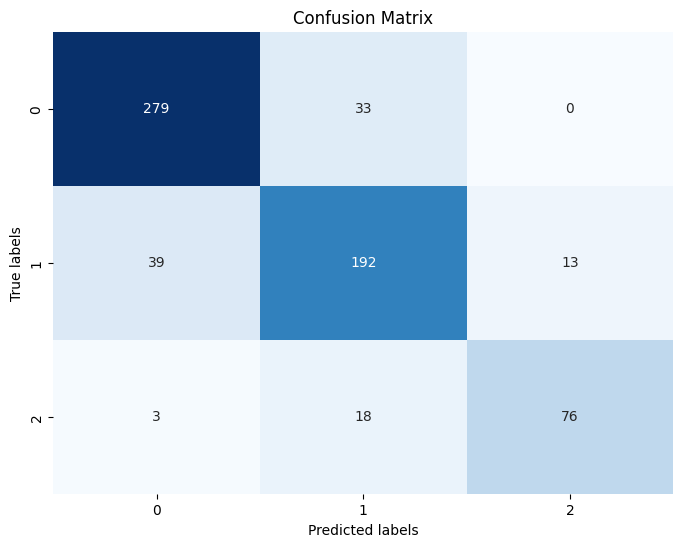

In [91]:
# 예측값 생성
y_pred = best_rfc.predict(X_test)

# 혼동 행렬 생성
cm = confusion_matrix(y_test, y_pred)

# 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, fmt='d', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

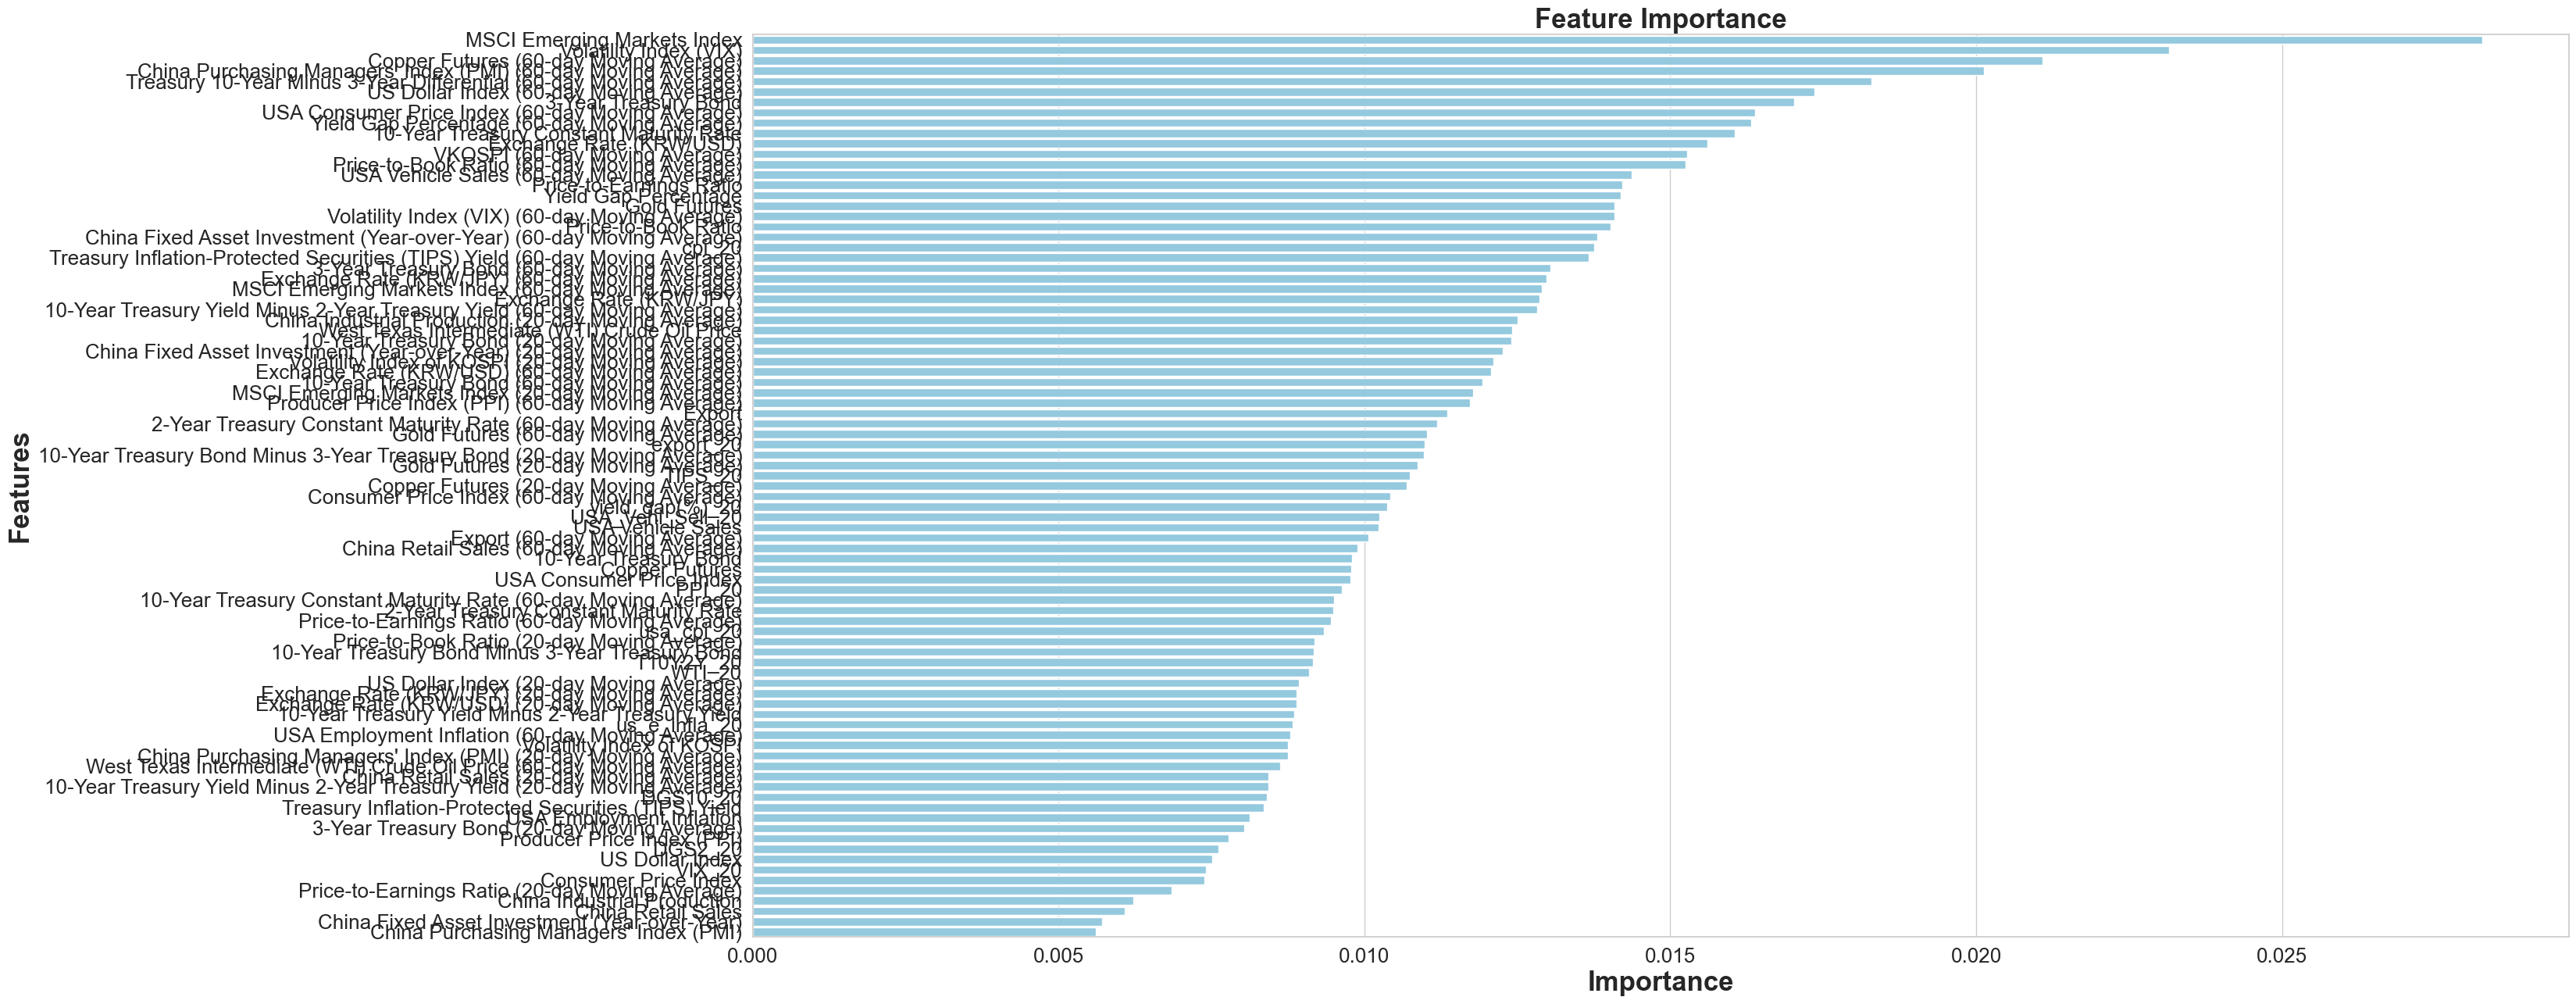

None

,Features,Gini-Importance
0,MSCI Emerging Markets Index,0.028270
1,Volatility Index (VIX),0.023148
2,Copper Futures (60-day Moving Average),0.021085
3,China Purchasing Managers' Index (PMI) (60-day...,0.020131
4,Treasury 10-Year Minus 3-Year Differential (60...,0.018283
5,US Dollar Index (60-day Moving Average),0.017363
6,3-Year Treasury Bond,0.017030
7,USA Consumer Price Index (60-day Moving Average),0.016393
8,Yield Gap Percentage (60-day Moving Average),0.016326
9,10-Year Treasury Constant Maturity Rate,0.016052


In [92]:
feats = {}
for feature, importance in zip(X,best_rfc.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances.head(10))
#auto =USA Vehicle Sales (60-day Moving Average)	0.024380
#construct= Volatility Index (VIX)	0.021660

### 너무 많다.. 10개로


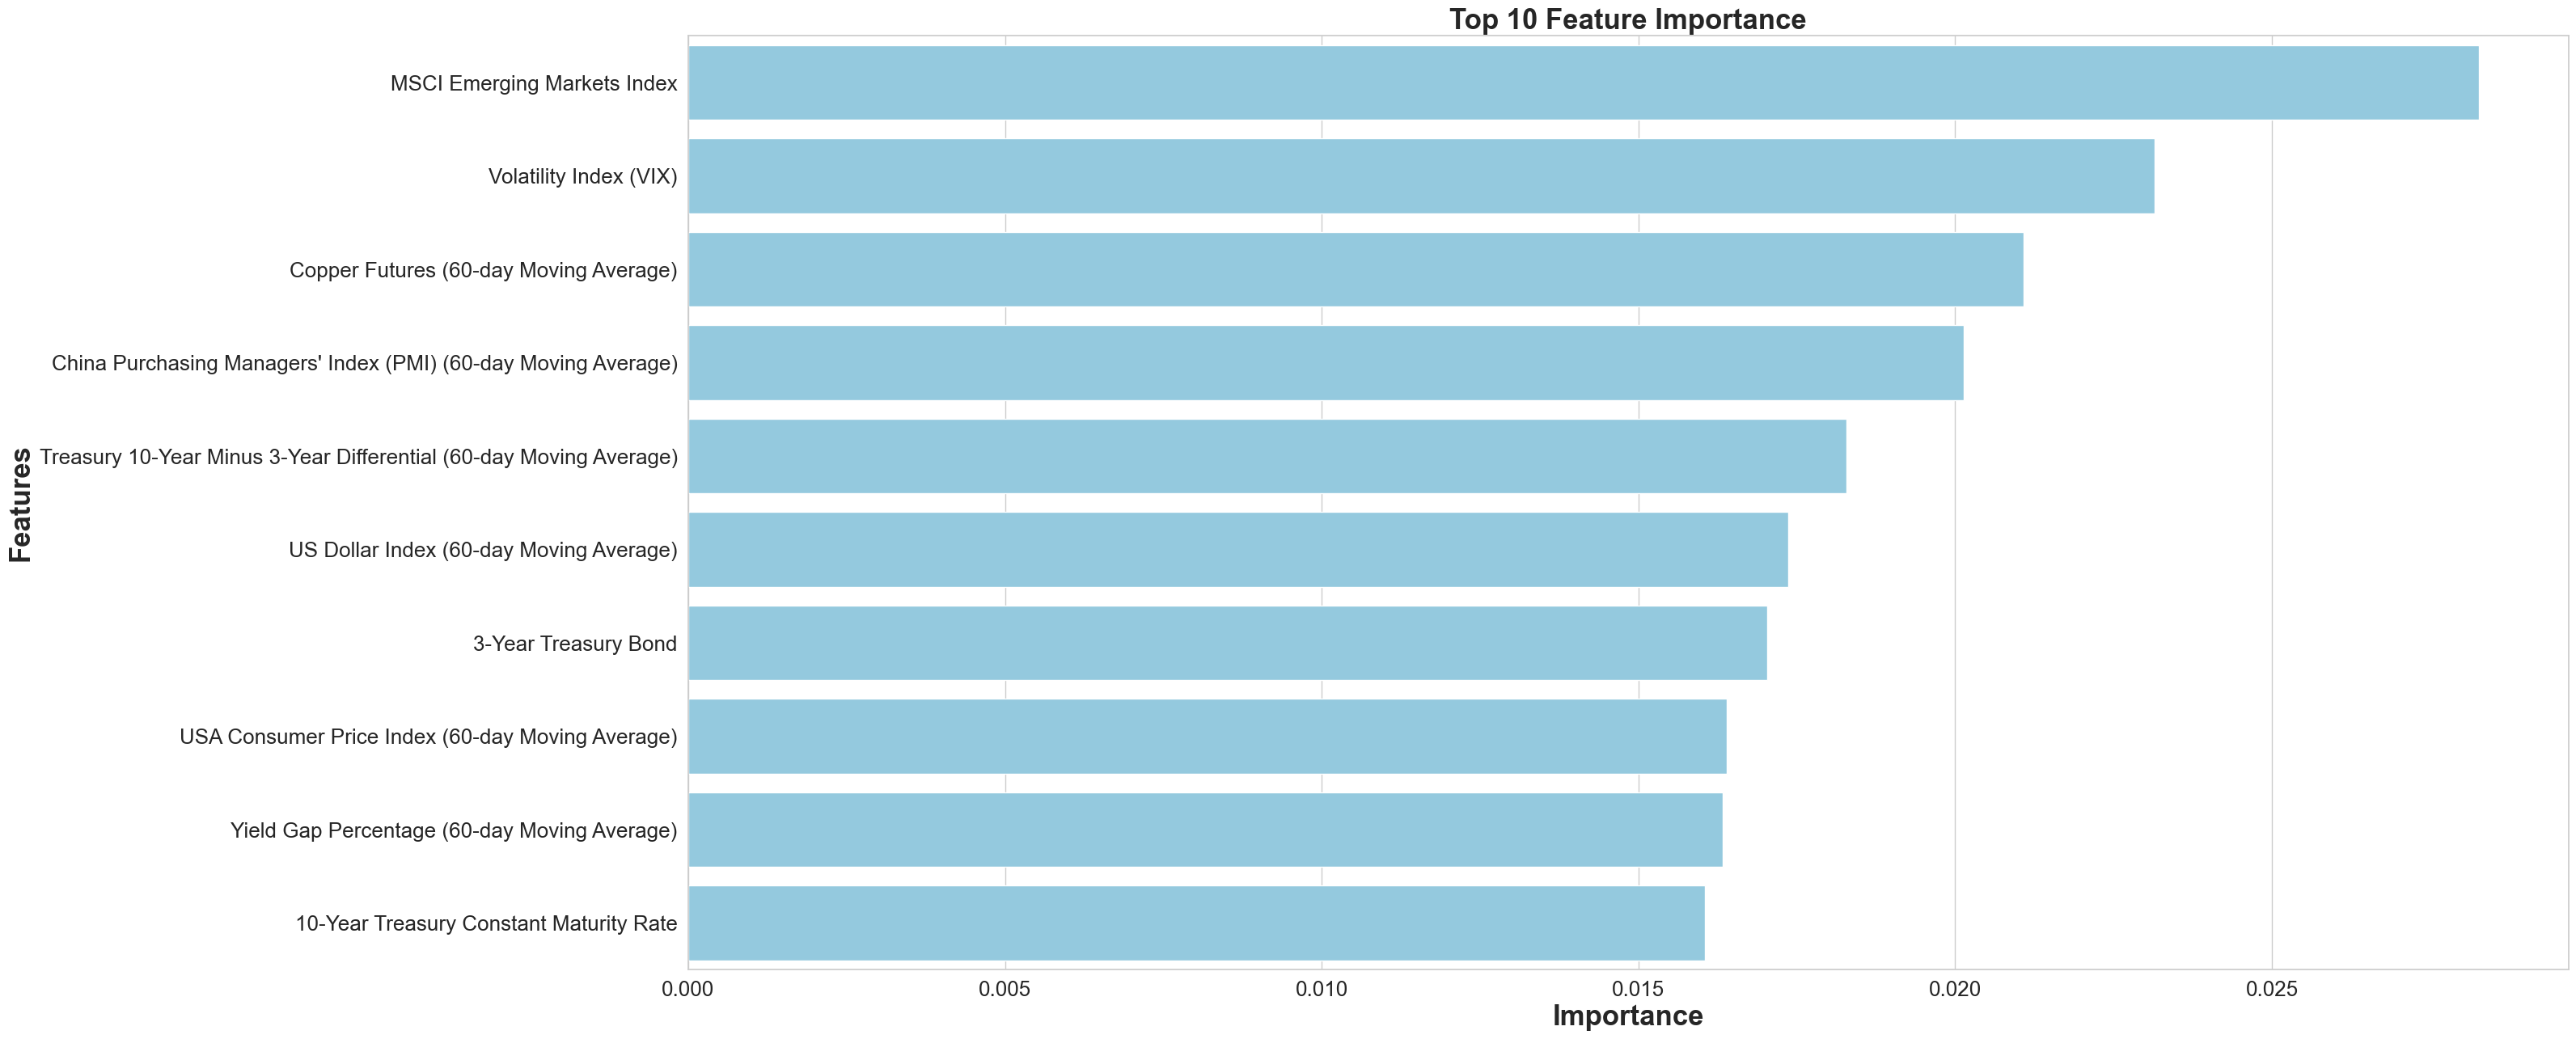

In [93]:
feats = {}
for feature, importance in zip(X, best_rfc.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
top_10_importances = importances.head(10)  # 상위 10개만 선택

sns.set(font_scale=1.7)
sns.set(style="whitegrid", color_codes=True, font_scale=1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30, 15)
sns.barplot(x=top_10_importances['Gini-Importance'], y=top_10_importances['Features'], data=top_10_importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight='bold')
plt.ylabel('Features', fontsize=25, weight='bold')
plt.title('Top 10 Feature Importance', fontsize=25, weight='bold')
plt.show()

### 생각보다 자동차지수와 중국 지표 금 구리 이런게 영향을 많이 미치는구마잉!

In [94]:
# 6. 최종 모델 학습
best_rfc.fit(X_train, y_train) 
#sheet_names = df.sheet_names

print("\n<AI model: machine learning done >") 
print("accuracy_score of train data(0.8 of sample): ", best_rfc.score(X_train, y_train))
print("\n")
print("accuracy_score of test data(0.2 of sample): ", best_rfc.score(X_test, y_test)) 
y_test_pred = best_rfc.predict(X_test) 
print("\n")
print("accuracy_score of test data: {:.4f}".format(mt.accuracy_score(y_test, y_test_pred)))
# auto :정확도:0.8270
# construct:정확도:0.8193
# capital_market: 정확도:0.8116
# chemicals : 정확도:0.8101
# equipment:정확도:0.8178
# media:정확도:0.8622
# insurance:정확도:0.8101
# transport:정확도:0.8025
# health_care:정확도:0.8193
# semi:정확도:0.8132
# bank:정확도:0.8239
# steel:정확도:0.8208
# staples: 정확도:0.8591
# discretionary:정확도:0.8530
# kospi:정확도:0.8943





<AI model: machine learning done >
accuracy_score of train data(0.8 of sample):  0.9992343032159265


accuracy_score of test data(0.2 of sample):  0.8376722817764165


accuracy_score of test data: 0.8377


In [95]:
# 10. backtesting용 과거의 예측데이터 생성
y_prediction = best_rfc.predict(X) 
y_pred = pd.Series(y_prediction, index=y.index) 


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [97]:
# 11. 모델 저장
joblib.dump(best_rfc, "kospi.pkl")
print("\n< AI model: save >")


< AI model: save >
